In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)

In [64]:
X, y = mnist['data'], mnist['target']
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# PCA

In [58]:
#using numpy on SWISS ROLL dataset below
X_train_centered = X_train - X_train.mean(axis=0)
U, s, Vt = np.linalg.svd(X_train_centered)
W2 = Vt.T[:,:2]
X_train_transformed = X_train_centered.dot(W2)

In [61]:
#using sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_train_2d = pca.fit_transform(X_train)

In [62]:
pca.explained_variance_ratio_

array([0.40165735, 0.32065789])

### Choosing the right number of dimensions

In [12]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum>=.95) + 1
pca_right = PCA(n_components = d)
X_train_trans = pca_right.fit_transform(X_train)

In [20]:
d

154

In [13]:
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X_train)

### Decompression

In [23]:
X_recovered = pca.inverse_transform(X_reduced)

Text(0.5, 1.0, 'Recovered')

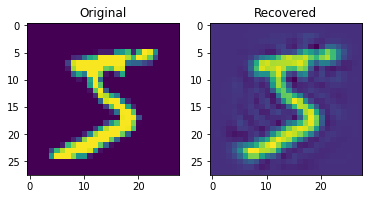

In [24]:
plt.subplot(1,2,1)
plt.imshow(X_train[0].reshape(28,28))
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(X_recovered[0].reshape(28,28))
plt.title('Recovered')

## Comparing the models

In [14]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
log_reg = LogisticRegression()

start_time = time.time()
log_reg.fit(X_train, y_train)
print("Accuracy:", accuracy_score(y_test,log_reg.predict(X_test)))
end_time = time.time()
print("Time Taken:", end_time-start_time)

Accuracy: 0.9255
Time Taken: 10.399670839309692


C:\Users\Atul PC\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [15]:
X_test_reduced = pca.transform(X_test)
start_time = time.time()
log_reg.fit(X_reduced, y_train)
print("Accuracy:", accuracy_score(y_test,log_reg.predict(X_test_reduced)))
end_time = time.time()
print("Time Taken:", end_time-start_time)

Accuracy: 0.9201
Time Taken: 5.124799013137817


C:\Users\Atul PC\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [11]:
from sklearn.svm import SVC
svm_clf = SVC()

start_time = time.time()
svm_clf.fit(X_train, y_train)
print("Accuracy:", accuracy_score(y_test,svm_clf.predict(X_test)))
end_time = time.time()
print("Time Taken:", end_time-start_time)

Accuracy: 0.9792
Time Taken: 1190.1011369228363


In [12]:
start_time = time.time()
svm_clf.fit(X_reduced, y_train)
print("Accuracy:", accuracy_score(y_test,svm_clf.predict(X_test_reduced)))
end_time = time.time()
print("Time Taken:", end_time-start_time)

Accuracy: 0.9832
Time Taken: 286.3052771091461


### Randomised PCA

In [15]:
rnd_pca = PCA(n_components=154, svd_solver='randomized')
X_rnd_red = rnd_pca.fit_transform(X_train)

### Incremental PCA

In [17]:
from sklearn.decomposition import IncrementalPCA
n_batches = 100
inc_pca = IncrementalPCA(n_components= 154)

for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
X_inc_red = inc_pca.fit_transform(X_train)

# Kernel PCA

In [50]:
from sklearn.datasets import make_swiss_roll
X,y = make_swiss_roll(n_samples=10000, noise=.15)

In [51]:
y = y/4
y = y.astype(np.int)

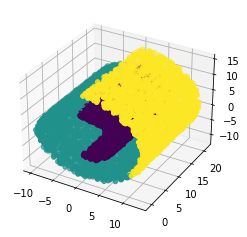

In [60]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X[:,0],X[:,1],X[:,2], c=y)

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3)

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import KernelPCA

kpca_clf = Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('log_reg', LogisticRegression())
])
param_grid = [{'kpca__gamma':np.linspace(0.03, 0.05, 5),
             'kpca__kernel':['rbf','sigmoid']}]
grid_search = GridSearchCV(kpca_clf, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.9s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'kpca__gamma': array([0.03 , 0.035, 0.04 , 0.045, 0.05 ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}],
             verbose=2)

In [39]:
grid_search.best_params_

{'kpca__gamma': 0.03, 'kpca__kernel': 'sigmoid'}

In [54]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

C:\Users\Atul PC\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

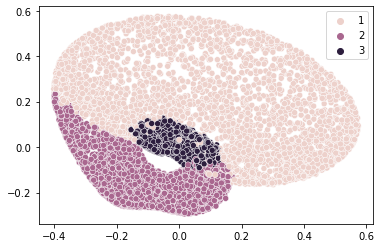

In [59]:
import seaborn as sns
sns.scatterplot(X_reduced[:,0], X_reduced[:,1] , hue=y)

In [56]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

1.0446068533041029e-25

# LLE

In [52]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

C:\Users\Atul PC\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

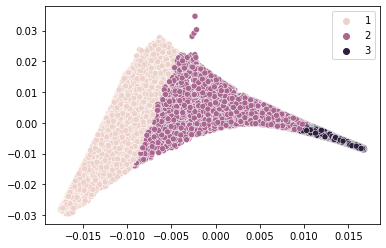

In [53]:
import seaborn as sns
sns.scatterplot(X_reduced[:,0], X_reduced[:,1] , hue=y)
#perfection!

# Exercises

In [79]:
from sklearn.ensemble import RandomForestClassifier
import time 

forest_clf1 = RandomForestClassifier(n_jobs=-1)
start_time = time.time()
forest_clf1.fit(X_train, y_train)
end_time = time.time()
print("Time Taken:", end_time-start_time, 'seconds')

Time Taken: 16.857909440994263 seconds


In [80]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, forest_clf1.predict(X_test))

0.9698

In [83]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

forest_clf2 = RandomForestClassifier(n_jobs=-1)
start_time = time.time()
forest_clf2.fit(X_train_reduced, y_train)
end_time = time.time()
print("Time Taken:", end_time-start_time, 'seconds')

Time Taken: 39.9363272190094 seconds


In [84]:
X_test_reduced = pca.transform(X_test)
accuracy_score(y_test, forest_clf2.predict(X_test_reduced))

0.9479

## t-SNE

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

tsne = TSNE(n_components=2)
X_train_scaled = StandardScaler().fit_transform(X_train)
X_train_reduced = tsne.fit_transform(X_train_scaled)
sns.scatterplot(X_train_reduced[0], X_train_reduced[1], hue=y_train)